In [66]:
from tqdm import tqdm
import numpy as np
import random
import os
from os.path import join
import math
import shutil
from shutil import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import albumentations.augmentations as A
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
np.random.seed(0)
random.seed(0)

In [67]:
dirs = ['test', 'train']

In [68]:
buff = os.listdir(dirs[1])

def getFilenames(path):
    out = []
    for dirpath, dirnames, filenames in os.walk(dirs[1]):
        dirpath = dirpath.replace('\\', '/')
        for file in filenames:
            if file.find('.jpg') > 0:
                out.append(f'{dirpath}/{file}')
    return out

if 'train' and 'val' in buff:
    shutil.rmtree(f'{dirs[1]}/train')
    shutil.rmtree(f'{dirs[1]}/val')
    os.makedirs(f'{dirs[1]}/train/cleaned')
    os.makedirs(f'{dirs[1]}/train/dirty')
    os.makedirs(f'{dirs[1]}/val/cleaned')
    os.makedirs(f'{dirs[1]}/val/dirty')
else:
    print(buff)
    os.makedirs(f'{dirs[1]}/train/cleaned')
    os.makedirs(f'{dirs[1]}/train/dirty')
    os.makedirs(f'{dirs[1]}/val/cleaned')
    os.makedirs(f'{dirs[1]}/val/dirty')

filenames = getFilenames(dirs[1])
for i, file in enumerate(filenames):
    if i % 5 == 0:
        name = 'cleaned' if 'cleaned' in file else 'dirty'
        copy(file, f'{dirs[1]}/val/{name}/{i}{name}.jpg')
    else:
        copy(file, f'{dirs[1]}/train/{name}/{i}{name}.jpg')

In [378]:
crop = 224
size = 256
transform = transforms.Compose([
    transforms.Resize([size, size]),
    transforms.CenterCrop([crop, crop]),
#     transforms.RandomRotation(30),
#     transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
#     transforms.RandomInvert(p=1),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transformval = transforms.Compose([
    transforms.Resize([size, size]),
    transforms.CenterCrop([crop, crop]),
#     transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainPath = 'train/train'
valPath = 'train/val'

trainData = ImageFolder('train/train', transform)
valData = ImageFolder('train/val', transformval)

batch_size = 8
num_workers = 0
train_loader = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [379]:
def normCalc(dataloader):
    channels, chsq, batch = 0, 0, 0
    for x, _ in dataloader:
        channels += x.mean([0,2,3])
        chsq += (x**2).mean([0,2,3])
        batch += 1
        
    mean = channels / batch
    std = (chsq / batch - mean ** 2) ** 0.5
    return mean, std

normCalc(train_loader)

(tensor([0.2259, 0.2174, 0.3775]), tensor([0.9736, 1.0597, 1.1200]))

In [380]:
def imshow(model, loader):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    model.eval()
    x, _ = next(iter(loader))
    pred = model(x)

    for i in range(len(x)):
        title = pred.argmax(dim=1).numpy()
        plt.imshow(x[i].permute(1,2,0).numpy()* std + mean)
        plt.title('dirty' if title[i] == 1 else 'cleaned')
        plt.show()
    
len(train_loader)

4

In [381]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.01E-03


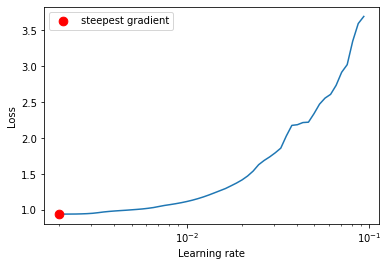

In [200]:
lr_finder = LRFinder(model, optimizer, loss, 'cpu')
lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1.0, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [382]:
train_loss = []
train_acc = []
val_acc = []
val_loss = []
def trainModel(model, loss, optimizer, epochs, scheduler=None):
    for epoch in range(epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
                
            for inputs, labels in tqdm(loader):
                inputs.to(device)
                labels.to(device)
                
                with torch.set_grad_enabled(phase == 'train'):
                    pred = model(inputs)
                    loss_value = loss(pred, labels)
                    acc = (pred.argmax(dim=1) == labels.data).float().mean()
                    
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss_value.backward()
                        optimizer.step()
                        train_loss.append(loss_value.data)
                        train_acc.append(acc)
                    else:
                        val_acc.append(acc)
                        val_loss.append(loss_value.data)
                    
#         scheduler.step(loss_value)
        scheduler.step()
        print(f"{epoch} acc {val_acc[-1]} loss {val_loss[-1]}")

In [383]:
trainModel(model, loss, optimizer, 100, scheduler)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


0 acc 0.375 loss 0.7386085987091064


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


1 acc 0.375 loss 0.8373207449913025


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


2 acc 0.375 loss 0.9078137874603271


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


3 acc 0.25 loss 0.9034183025360107


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


4 acc 0.5 loss 1.055441975593567


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


5 acc 0.5 loss 1.1000394821166992


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


6 acc 0.375 loss 1.0726594924926758


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


7 acc 0.5 loss 1.0794482231140137


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


8 acc 0.375 loss 1.0303230285644531


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


9 acc 0.5 loss 1.0602349042892456


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


10 acc 0.5 loss 1.0896884202957153


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


11 acc 0.5 loss 1.0891350507736206


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


12 acc 0.5 loss 1.1125619411468506


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


13 acc 0.5 loss 1.1153984069824219


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


14 acc 0.5 loss 1.1416106224060059


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


15 acc 0.5 loss 1.134912371635437


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


16 acc 0.5 loss 1.1347575187683105


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


17 acc 0.5 loss 1.1017779111862183


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


18 acc 0.5 loss 1.1138663291931152


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


19 acc 0.5 loss 1.1214244365692139


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


20 acc 0.5 loss 1.1259417533874512


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


21 acc 0.5 loss 1.1208984851837158


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


22 acc 0.5 loss 1.1242595911026


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


23 acc 0.5 loss 1.1115562915802002


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


24 acc 0.5 loss 1.1212941408157349


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


25 acc 0.5 loss 1.1310547590255737


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


26 acc 0.5 loss 1.1132584810256958


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


27 acc 0.5 loss 1.1256197690963745


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


28 acc 0.5 loss 1.1275218725204468


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


29 acc 0.5 loss 1.1283284425735474


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


30 acc 0.5 loss 1.1009814739227295


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


31 acc 0.5 loss 1.127916932106018


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


32 acc 0.5 loss 1.1234745979309082


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


33 acc 0.5 loss 1.1337417364120483


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


34 acc 0.5 loss 1.1326842308044434


 50%|█████████████████████████████████████████▌                                         | 2/4 [00:02<00:02,  1.25s/it]


KeyboardInterrupt: 

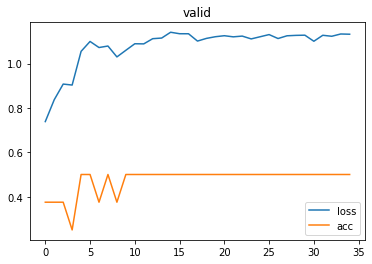

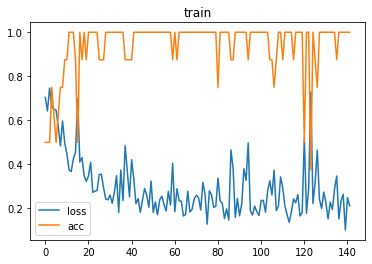

In [384]:
plt.plot(val_loss)
plt.plot(val_acc)
plt.title('valid')
plt.legend(["loss", "acc"])
plt.show()
plt.plot(train_loss)
plt.plot(train_acc)
plt.title("train")
plt.legend(["loss", "acc"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


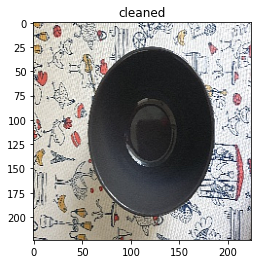

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


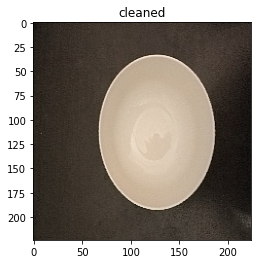

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


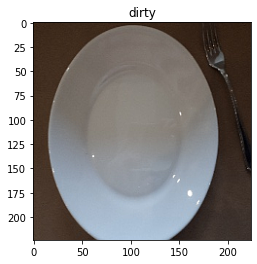

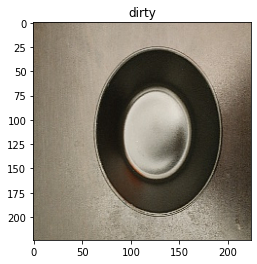

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


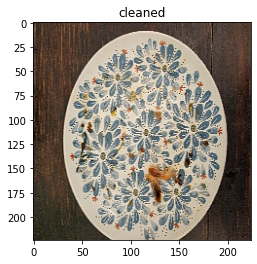

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


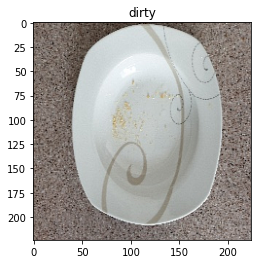

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


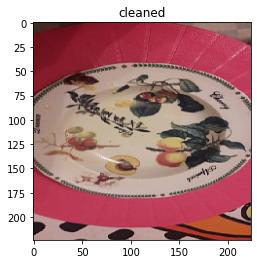

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


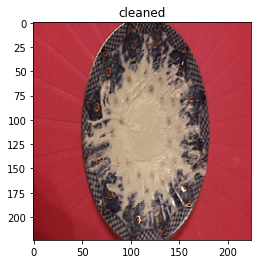

In [361]:
imshow(model, val_loader)